# Infectious Pulse
https://github.com/alvason/infectious-pulse/

### Many-strain SIR evolution --- its equilibrium state and infectious pulse due to mutation

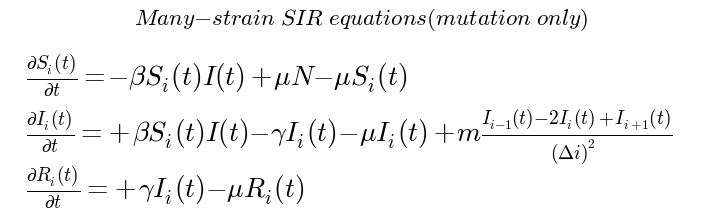

In [1]:
'''
author: Alvason Zhenhua Li
date:   03/23/2015
'''
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import time
import os
dir_path = '/Users/al/Desktop/GitHub/infectious-pulse/figure'
file_name = 'sir-array-mutation'

import alva_machinery as alva

AlvaFontSize = 23
AlvaFigSize = (9, 7)
numberingFig = 0

numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize=(12,3))
plt.axis('off')
plt.title(r'$ Many-strain \ SIR \ equations (mutation \ only) $',fontsize = AlvaFontSize)
plt.text(0,2.0/3,r'$ \frac{\partial S_i(t)}{\partial t} = \
         -\beta S_i(t)I(t) +\mu N -\mu S_i(t)$', fontsize = 1.2*AlvaFontSize)
plt.text(0,1.0/3,r'$ \frac{\partial I_i(t)}{\partial t} = \
         +\beta S_i(t)I(t) - \gamma I_i(t) -\mu I_i(t) + m \frac{I_{i-1}(t) - 2I_i(t) + I_{i+1}(t)}{(\Delta i)^2}$'
         , fontsize = 1.2*AlvaFontSize)
plt.text(0,0.0/3,r'$ \frac{\partial R_i(t)}{\partial t} = \
         +\gamma I_i(t) - \mu R_i(t) $', fontsize = 1.2*AlvaFontSize)
plt.show()

# define many -strain S-I-R equation
def dSdt_array(SIRxt = [], *args):
    # naming
    S = SIRxt[0]
    I = SIRxt[1]
    R = SIRxt[2]
    x_totalPoint = SIRxt.shape[1]
    # there are n dSdt
    dS_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    dS_dt_array[:] = -infecRate*S[:]*I[:] + inOutRate*totalSIR - inOutRate*S[:]
    return(dS_dt_array)

def dIdt_array(SIRxt = [], *args):
    # naming
    S = SIRxt[0]
    I = SIRxt[1]
    R = SIRxt[2]
    x_totalPoint = SIRxt.shape[1]
    # there are n dIdt
    dI_dt_array = np.zeros(x_totalPoint)
    # each dIdt with the same equation form
    Icopy = np.copy(I)
    centerX = Icopy[:]
    leftX = np.roll(Icopy[:], 1)
    rightX = np.roll(Icopy[:], -1)
    leftX[0] =centerX[0]
    rightX[-1] = centerX[-1]
    dI_dt_array[:] = + infecRate*S[:]*I[:] - recovRate*I[:] - inOutRate*I[:] \
                     + mutatRate*(leftX[:] - 2*centerX[:] + rightX[:])/(dx**2)
    return(dI_dt_array)
def dRdt_array(SIRxt = [], *args):
    # naming
    S = SIRxt[0]
    I = SIRxt[1]
    R = SIRxt[2]
    x_totalPoint = SIRxt.shape[1]
    # there are n dRdt
    dR_dt_array = np.zeros(x_totalPoint)
    # each dIdt with the same equation form
    dR_dt_array[:] = + recovRate*I[:] - inOutRate*R[:]
    return(dR_dt_array)

('machinery running time =', 18.415606021881104)


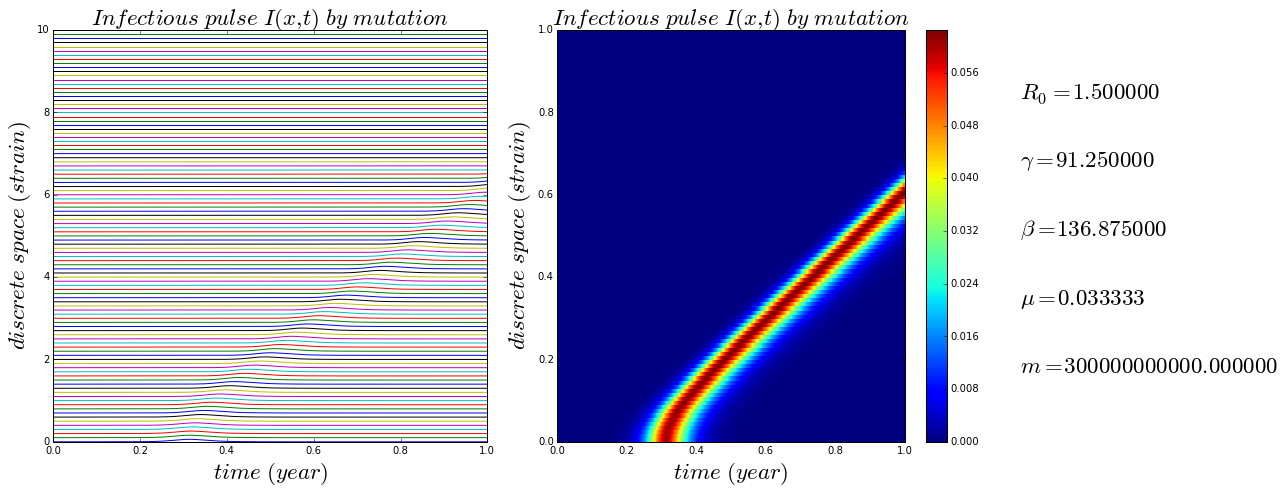

In [2]:
# setting parameter
timeUnit = 'year'
if timeUnit == 'day':
    day = 1
    year = 365 
elif timeUnit == 'year':
    year = 1
    day = float(1)/365
    
totalSIR = float(1) # total population
reprodNum = 1.5 # basic reproductive number R0: one infected person will transmit to 1.8 person 
recovRate = float(1)/(4*day) # 4 days per period ==> rate/year = 365/4
infecRate = reprodNum*recovRate/totalSIR # per year, per person, per total-population
inOutRate = float(1)/(30*year) # birth rate per year
mutatRate = float(3)/10**3 # mutation rate

# time boundary and griding condition
minT = float(0)*year
maxT = float(1)*year
totalPoint_T = int(10**3 + 1)
spacingT = np.linspace(minT, maxT, num = totalPoint_T, retstep = True)
gT = spacingT[0]
dt = spacingT[1]

# space boundary and griding condition
minX = float(0)
maxX = float(1)
totalPoint_X = int(maxX*100 + 1)
gridingX = np.linspace(minX, maxX, num = totalPoint_X, retstep = True)
gX = gridingX[0]
dx = gridingX[1]

gS_array = np.zeros([totalPoint_X, totalPoint_T])
gI_array = np.zeros([totalPoint_X, totalPoint_T])
gR_array = np.zeros([totalPoint_X, totalPoint_T])

# initial output condition (only one virus in equilibrium condition)
gS_array[:, 0] = np.ones(totalPoint_X)*totalSIR
#gS_array[0, 0] = (recovRate + inOutRate)/infecRate
#gI_array[0, 0] = inOutRate*(totalSIR - gS_array[0, 0])/(infecRate*gS_array[0, 0])
#gR_array[0, 0] = totalSIR - gS_array[0, 0] - gI_array[0, 0]

gI_array[0, 0] = float(1)/10**6
gR_array[0, 0] = float(0)
gS_array[0, 0] = totalSIR - gI_array[0, 0] - gR_array[0, 0]

# Runge Kutta numerical solution
time_start = time.time()
pde_array = np.array([dSdt_array, dIdt_array, dRdt_array])
startingOut_Value = np.array([gS_array, gI_array, gR_array])
gOut_array = alva.AlvaRungeKutta4ArrayXT(pde_array, startingOut_Value, minX, maxX, totalPoint_X, minT, maxT, totalPoint_T)
time_stop = time.time()
print ('machinery running time =', time_stop - time_start)
# plotting
gS = gOut_array[0]  
gI = gOut_array[1]
gR = gOut_array[2]

numberingFig = numberingFig + 1;
figure = plt.figure(numberingFig, figsize = (14, 7))
plot1 = figure.add_subplot(1, 2, 2)
#colorPlot = plot1.contourf(gT, gX, gI, levels = np.arange(0, 0.12, 0.001))
colorPlot = plot1.pcolor(gT, gX, gI)
plt.title(r'$ Infectious \ pulse \ I(x,t) \ by \ mutation $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize);
plt.ylabel(r'$ discrete \ space \ (strain) $', fontsize = AlvaFontSize);
plt.text(maxT*4.0/3, maxX*5.0/6, r'$ R_0 = %f $'%(reprodNum), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*4.0/6, r'$ \gamma = %f $'%(recovRate), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*3.0/6, r'$ \beta = %f $'%(infecRate), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*2.0/6, r'$ \mu = %f $'%(inOutRate), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*1.0/6, r'$ m = %f $'%(mutatRate*10**14), fontsize = AlvaFontSize)
plt.colorbar(colorPlot)

plot2 = figure.add_subplot(1, 2, 1)
plot2.plot(gT, (gI.T + np.arange(totalPoint_X)*0.1))
plt.title(r'$ Infectious \ pulse \ I(x,t) \ by \ mutation  $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ discrete \ space \ (strain) $', fontsize = AlvaFontSize)

figure.tight_layout()
plt.show()

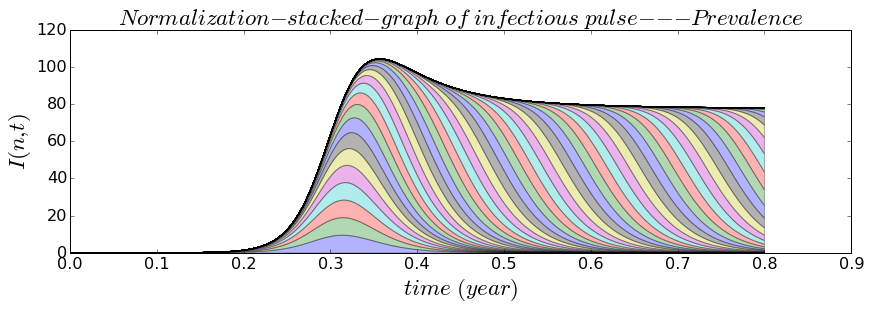

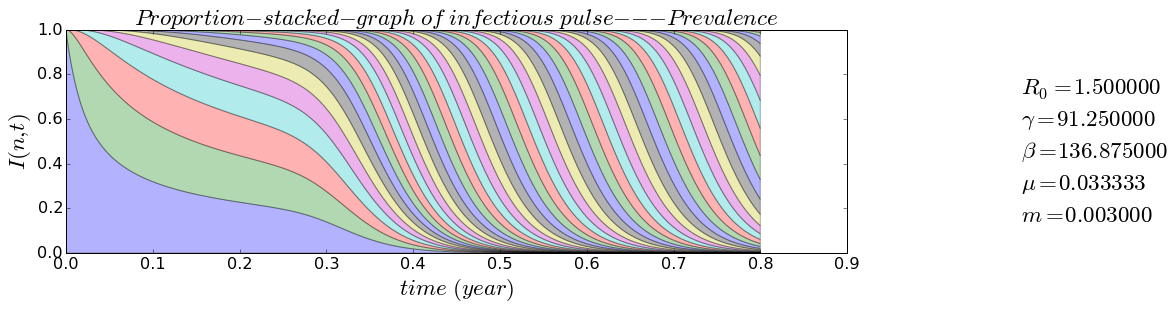

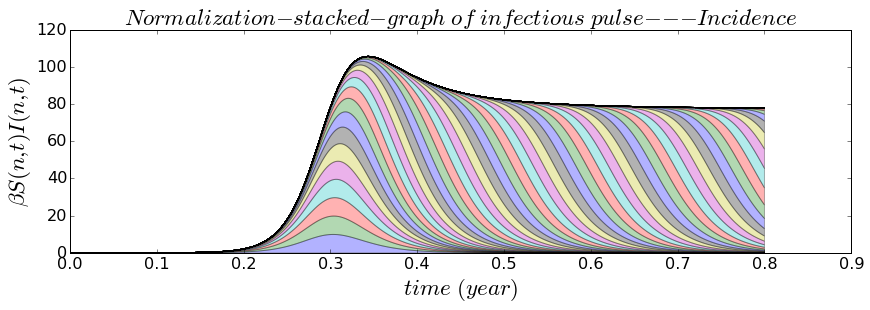

In [3]:
# Normalization stacked graph
cutting_X = -1
cutting_T = -200
gI_N = np.copy(gI)
for xn in range(totalPoint_X):
    gI_N[xn, :] = gI_N[xn, :]/np.sum(gI_N[xn, :]*dt)
numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize = (14, 4))
plt.stackplot(gT[:cutting_T], gI_N[:cutting_X, :cutting_T], alpha = 0.3)
plt.title(r'$ Normalization-stacked-graph \ of \ infectious \ pulse---Prevalence $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ I(n,t) $', fontsize = AlvaFontSize)
plt.xticks(fontsize = AlvaFontSize*0.7)
plt.yticks(fontsize = AlvaFontSize*0.7) 
plt.show()

# Proportion stacked graph
gI_P = np.copy(gI)
for tn in range(totalPoint_T):
    gI_P[:, tn] = gI_P[:, tn]/np.sum(gI_P[:, tn])
numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize = (14, 4))
plt.stackplot(gT[:cutting_T], gI_P[:cutting_X, :cutting_T], alpha = 0.3)
plt.title(r'$ Proportion-stacked-graph \ of \ infectious \ pulse---Prevalence $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ I(n,t) $', fontsize = AlvaFontSize)
plt.ylim(0, 1)
plt.text(maxT*1.1, totalSIR*5.0/7, r'$ R_0 = %f $'%(reprodNum), fontsize = AlvaFontSize)
plt.text(maxT*1.1, totalSIR*4.0/7, r'$ \gamma = %f $'%(recovRate), fontsize = AlvaFontSize)
plt.text(maxT*1.1, totalSIR*3.0/7, r'$ \beta = %f $'%(infecRate), fontsize = AlvaFontSize)
plt.text(maxT*1.1, totalSIR*2.0/7, r'$ \mu = %f $'%(inOutRate), fontsize = AlvaFontSize)
plt.text(maxT*1.1, totalSIR*1.0/7, r'$ m = %f $'%(mutatRate), fontsize = AlvaFontSize)
plt.xticks(fontsize = AlvaFontSize*0.7)
plt.yticks(fontsize = AlvaFontSize*0.7) 
plt.show()

# Normalization stacked graph of Incidence
gInc = np.zeros([totalPoint_X, totalPoint_T])
for xn in range(totalPoint_X):
    gInc[xn, :] = infecRate*gS[xn, :]*gI[xn, :]/np.sum(infecRate*gS[xn, :]*gI[xn, :]*dt)
numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize = (14, 4))
plt.stackplot(gT[:cutting_T], gInc[:cutting_X, :cutting_T], alpha = 0.3)
plt.title(r'$ Normalization-stacked-graph \ of \ infectious \ pulse---Incidence $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ \beta S(n,t)I(n,t) $', fontsize = AlvaFontSize)
plt.xticks(fontsize = AlvaFontSize*0.7)
plt.yticks(fontsize = AlvaFontSize*0.7) 
plt.show()

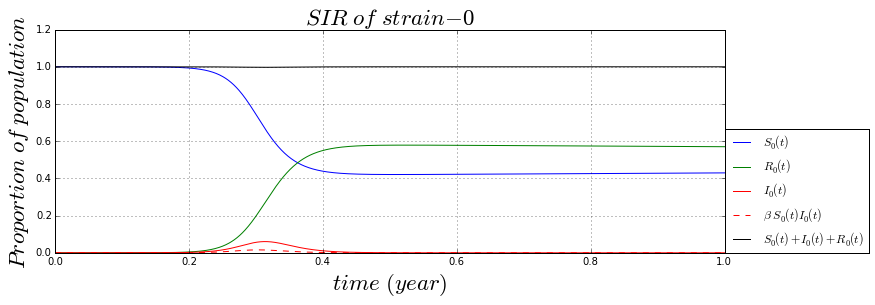

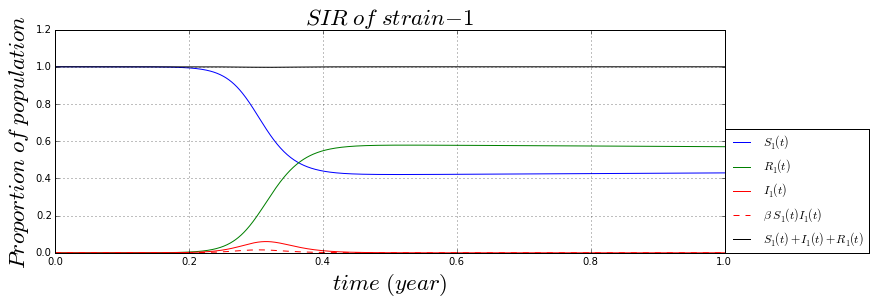

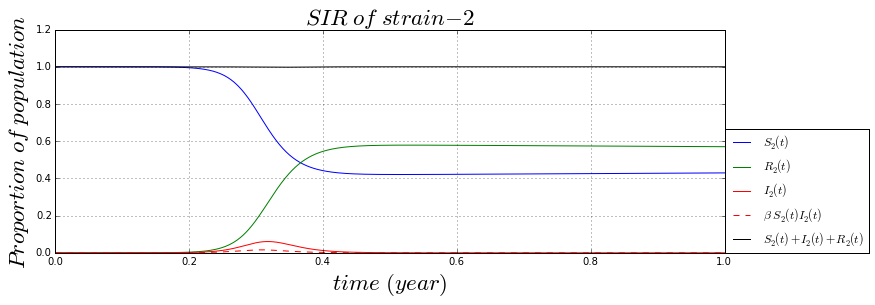

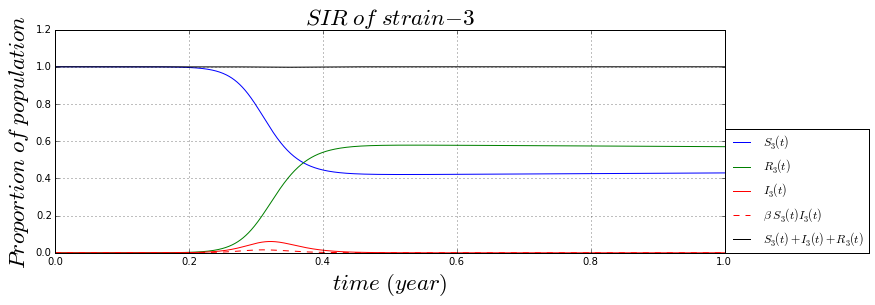

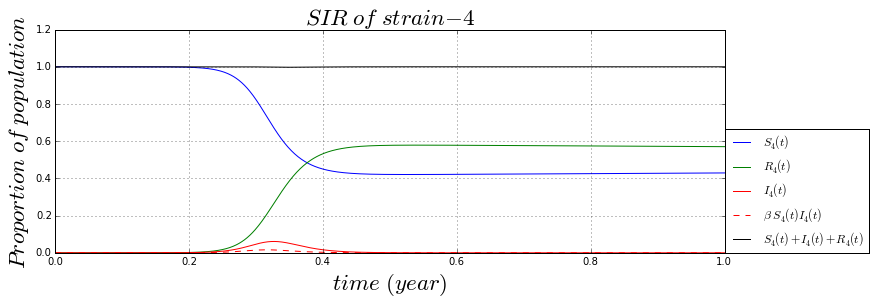

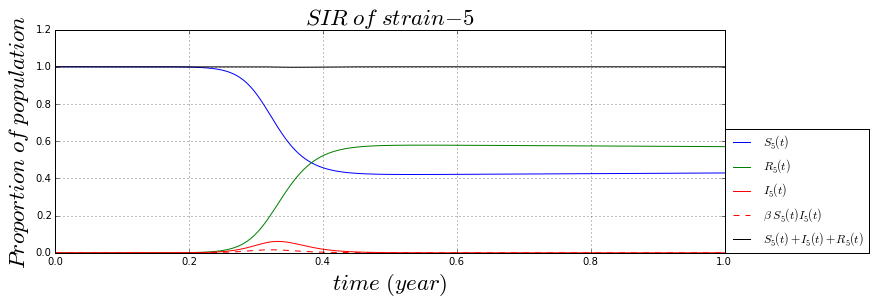

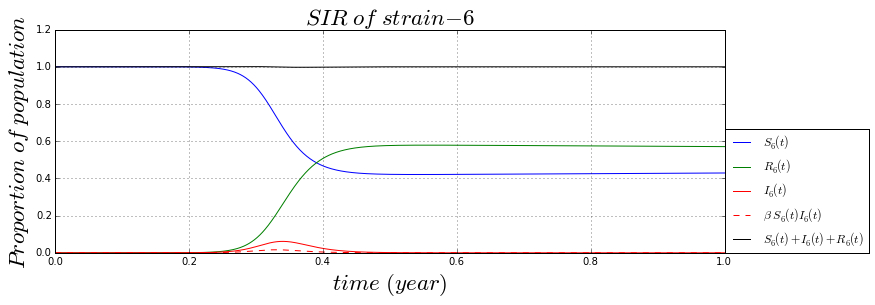

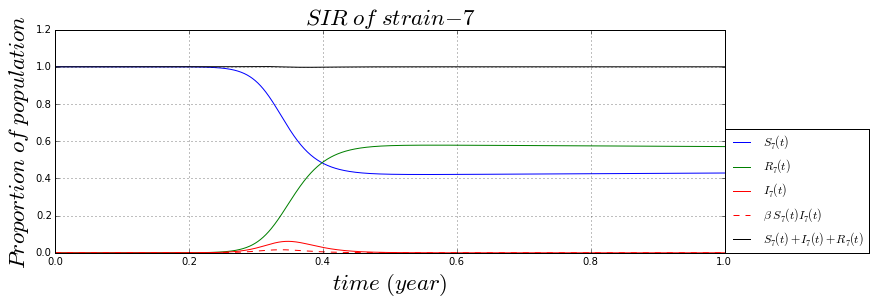

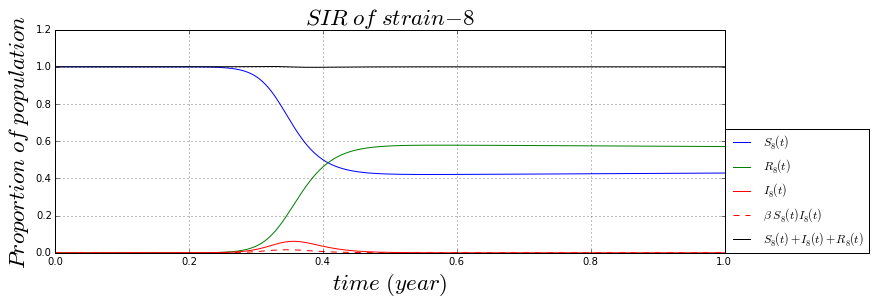

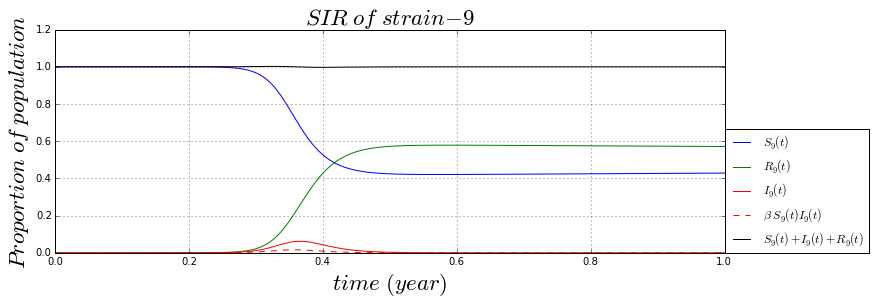

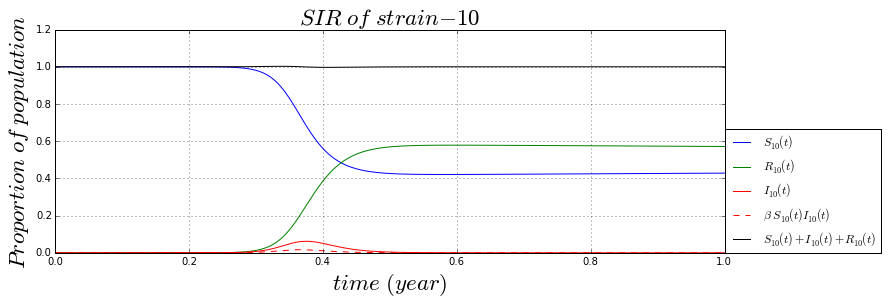

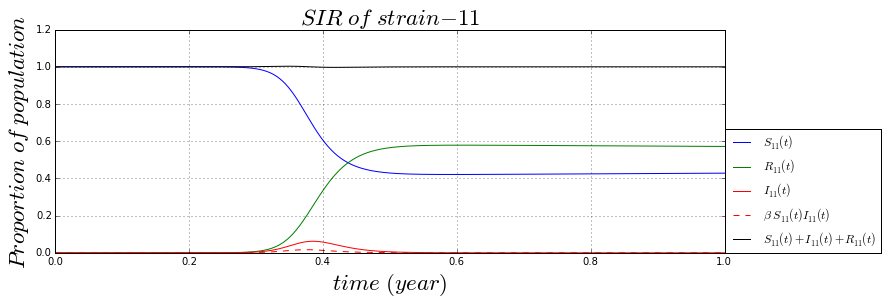

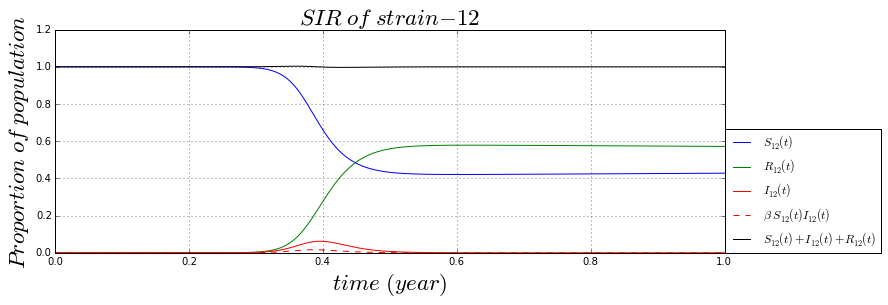

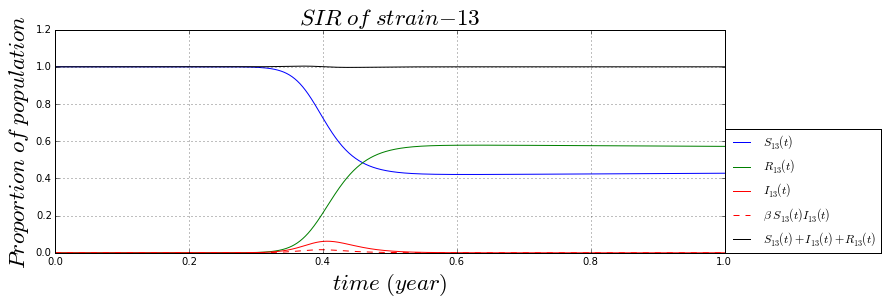

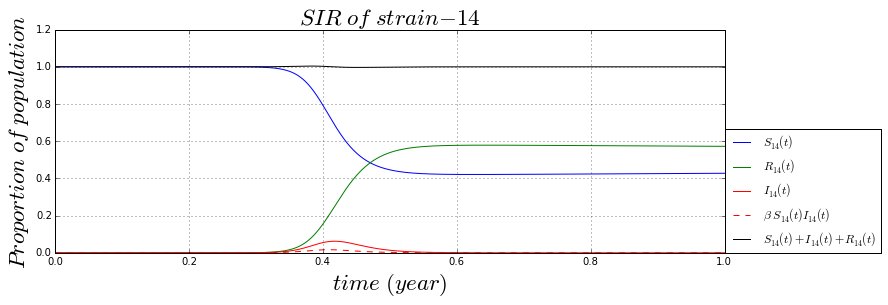

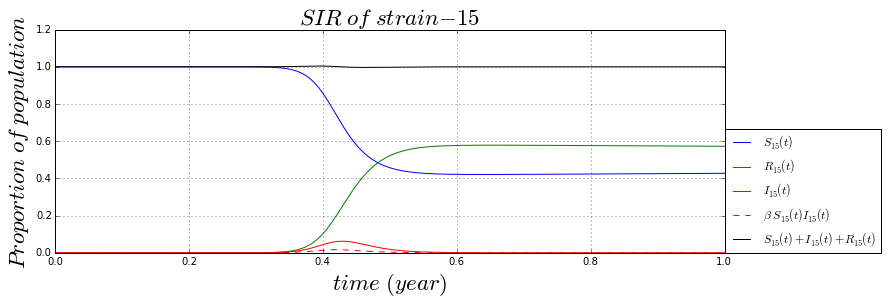

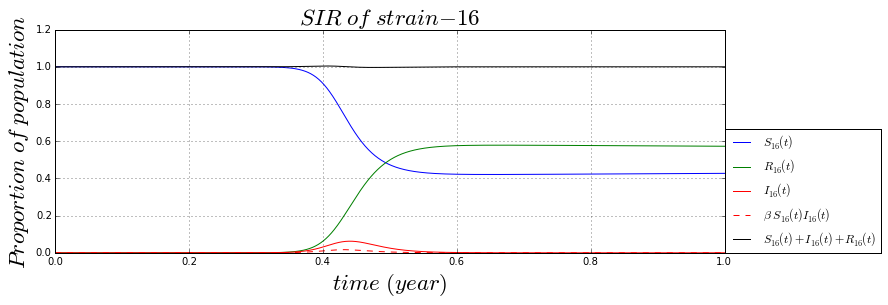

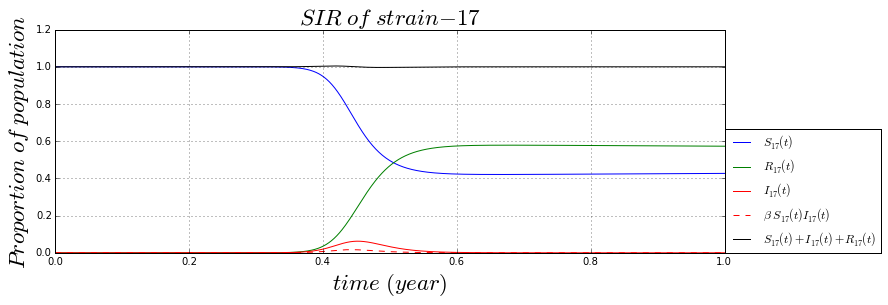

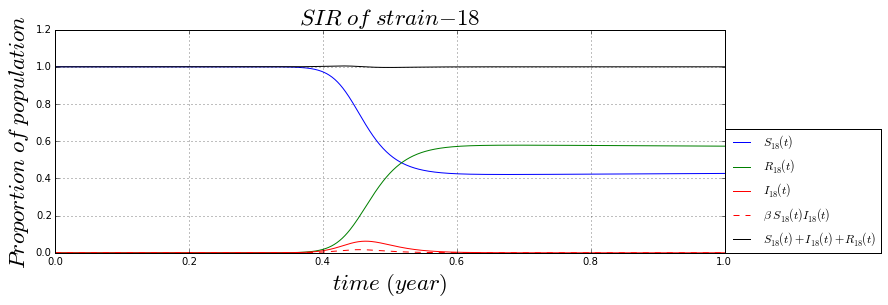

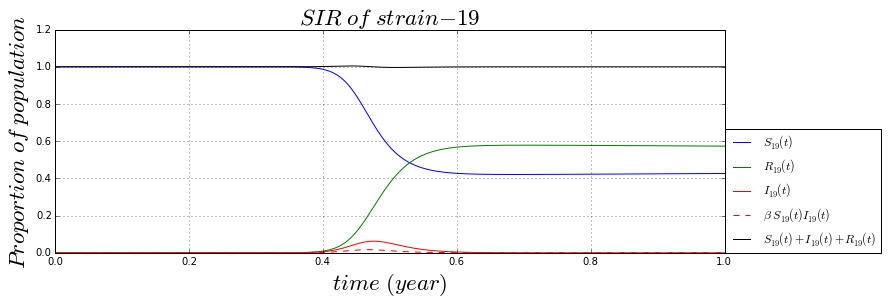

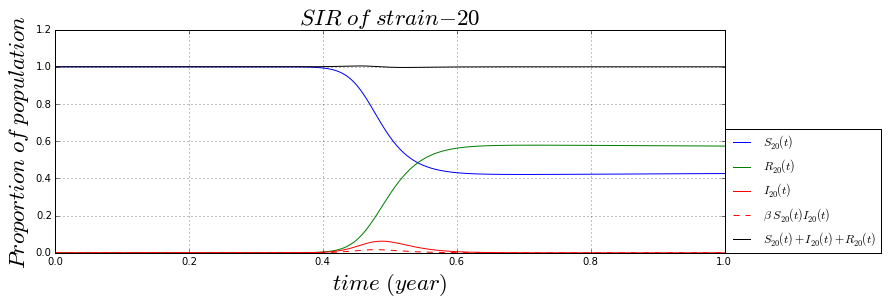

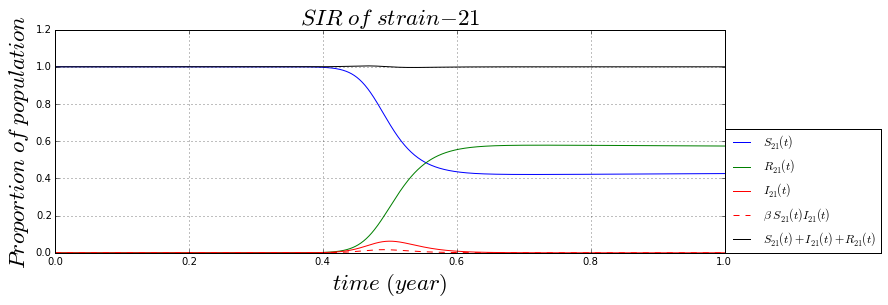

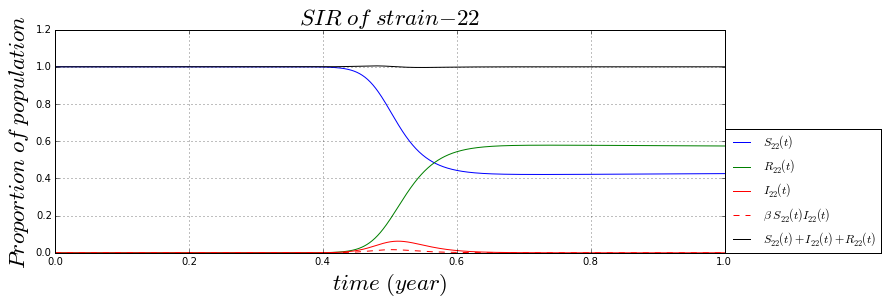

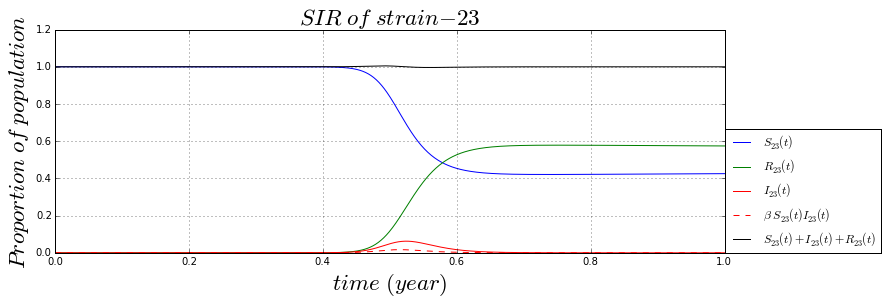

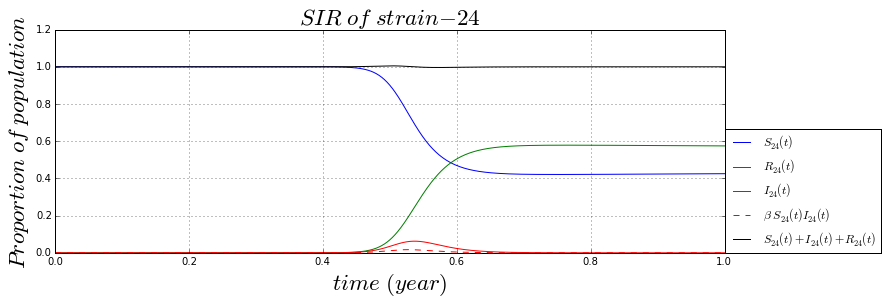

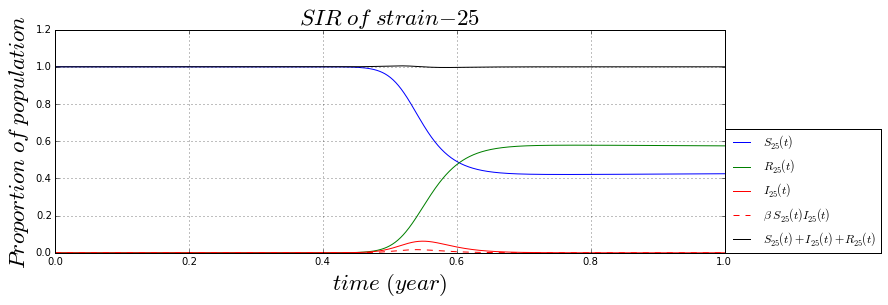

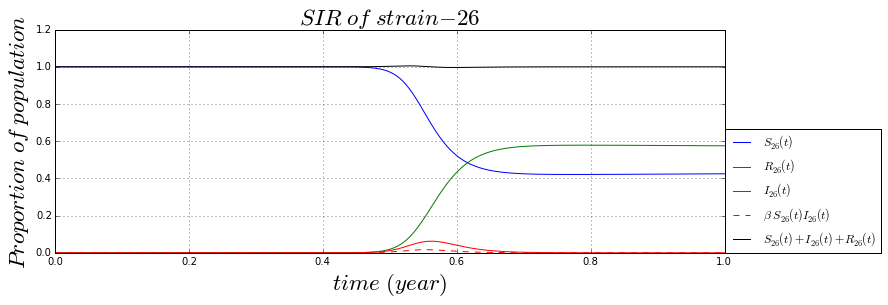

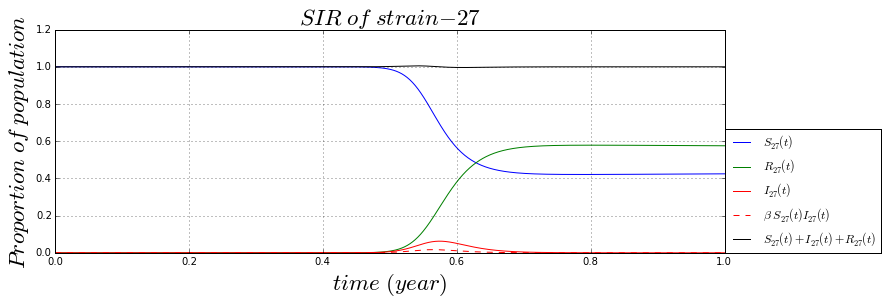

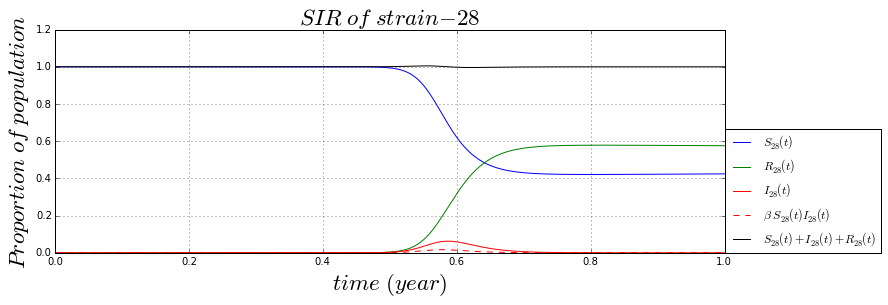

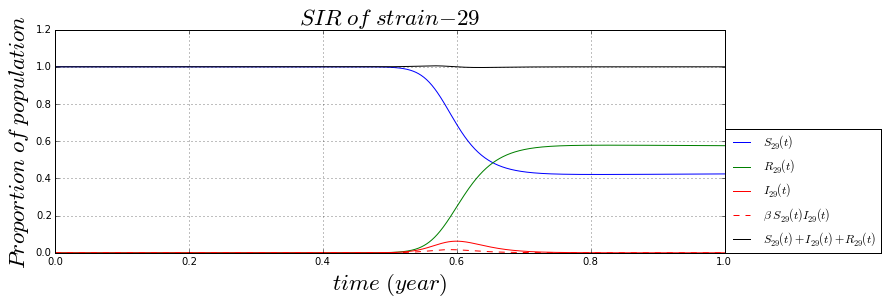

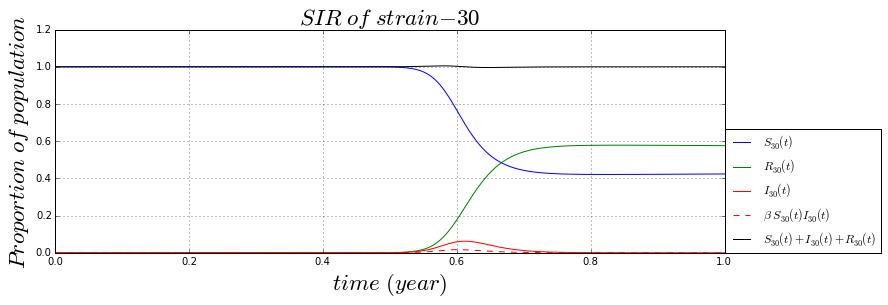

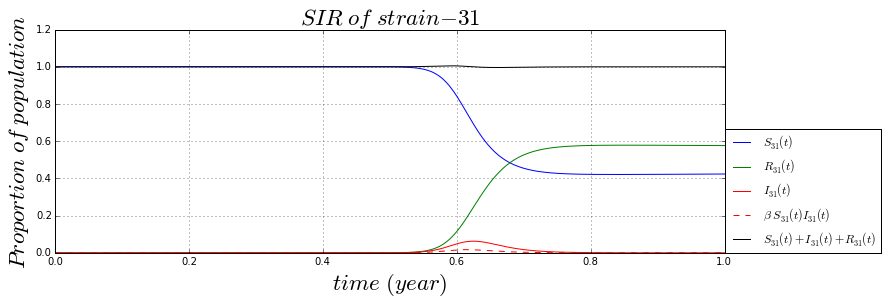

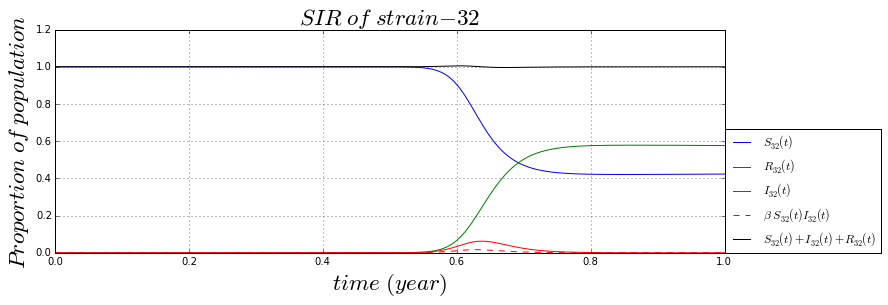

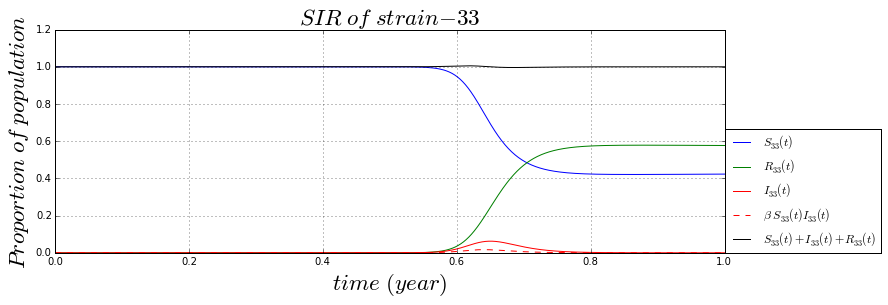

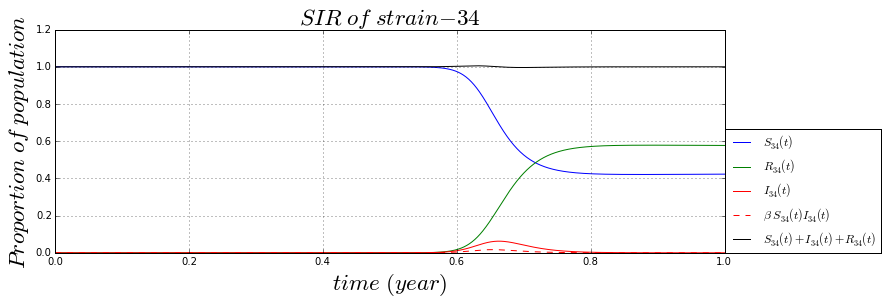

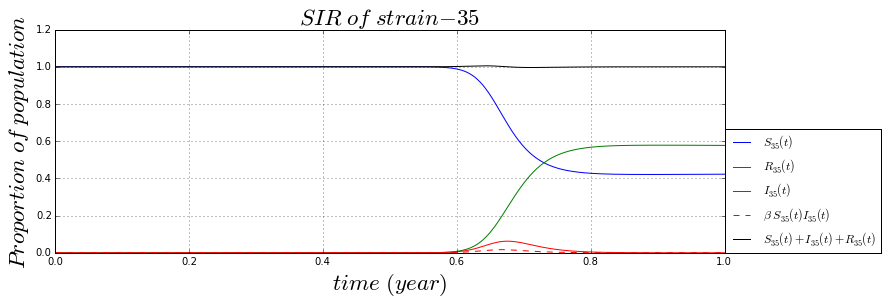

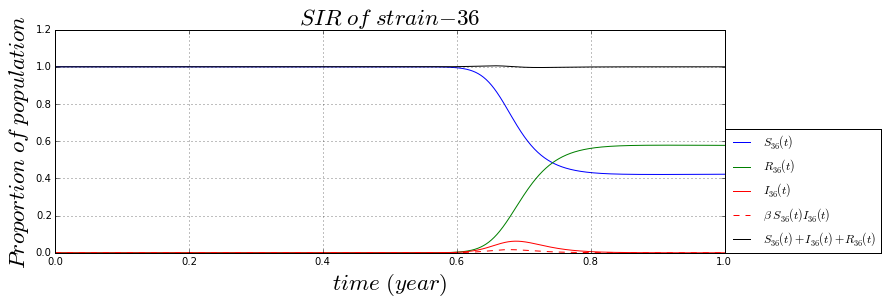

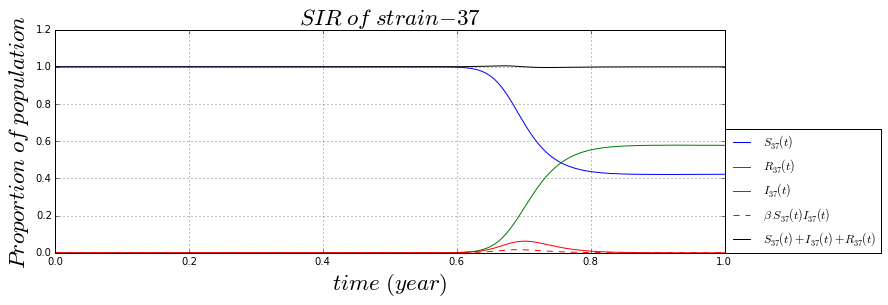

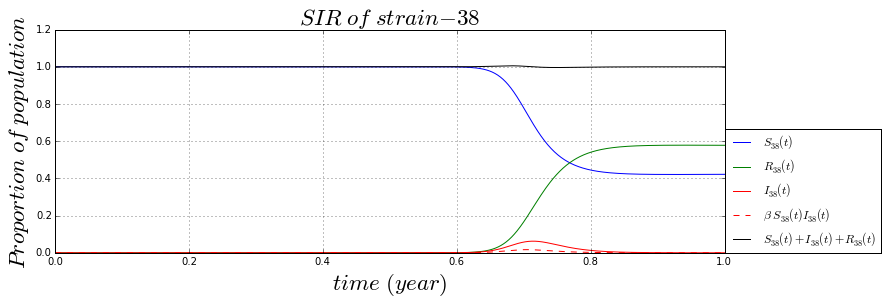

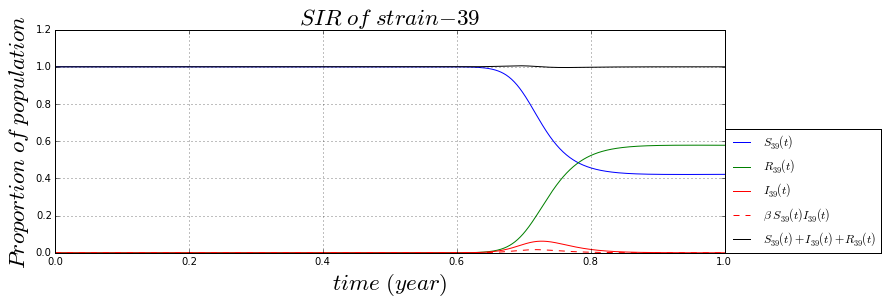

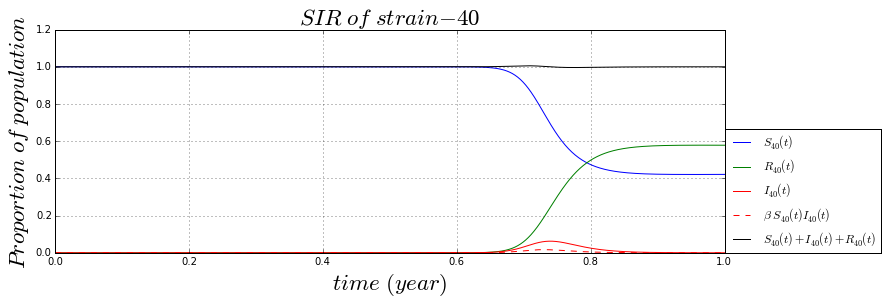

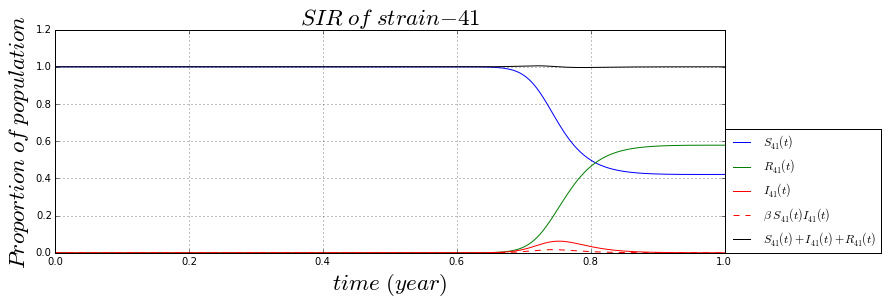

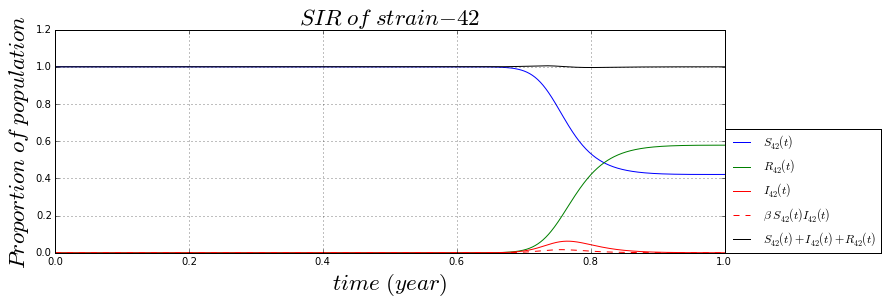

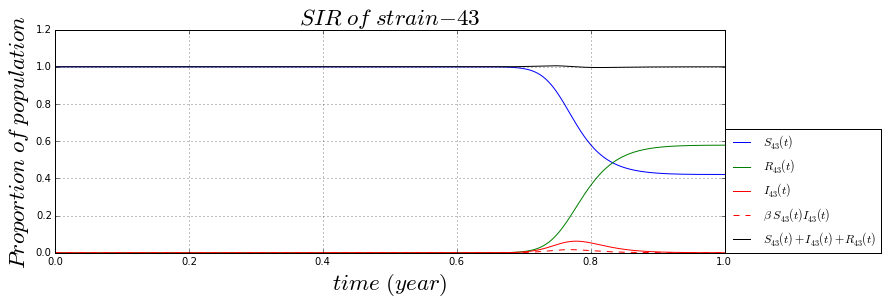

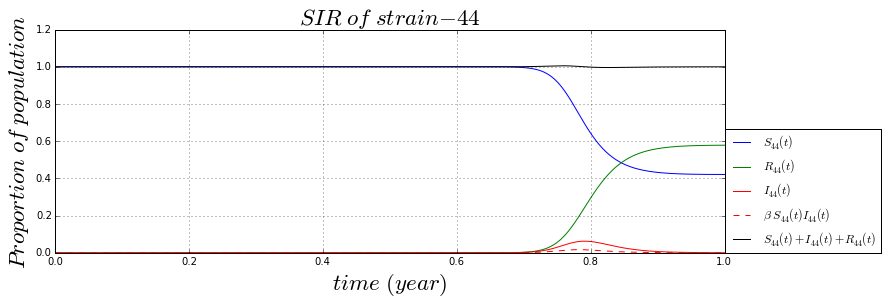

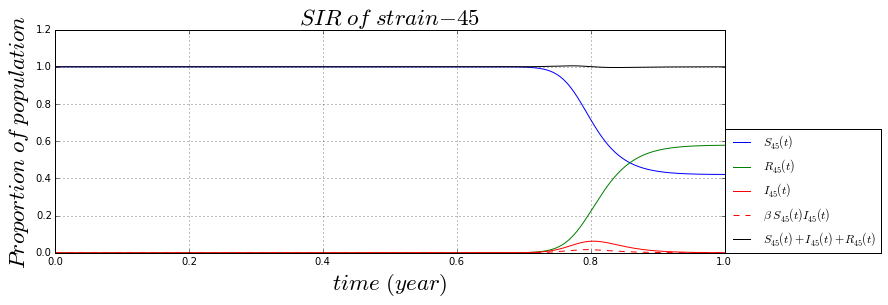

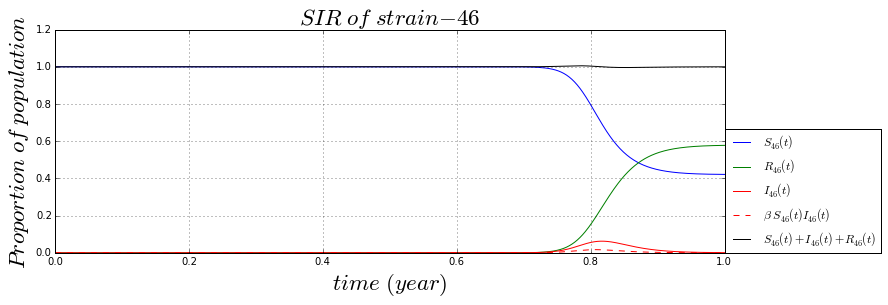

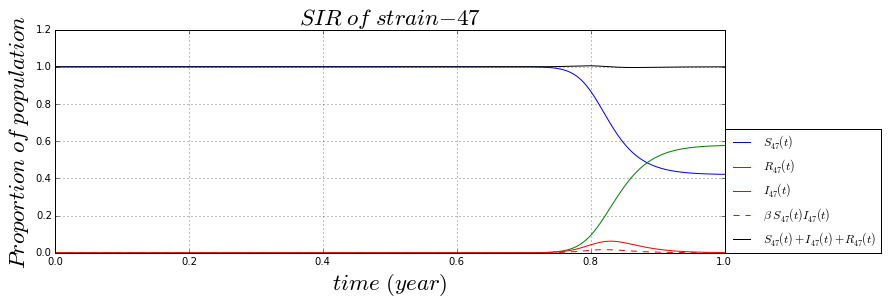

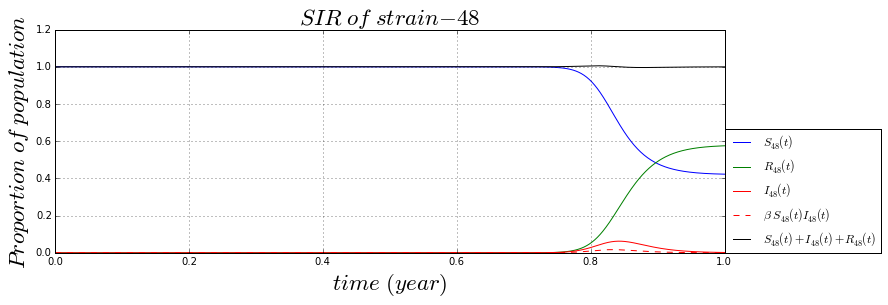

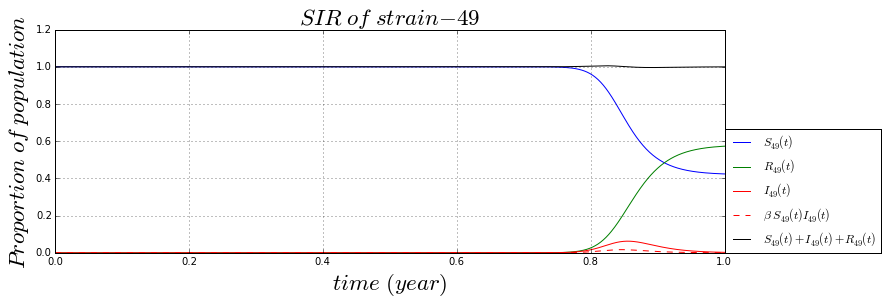

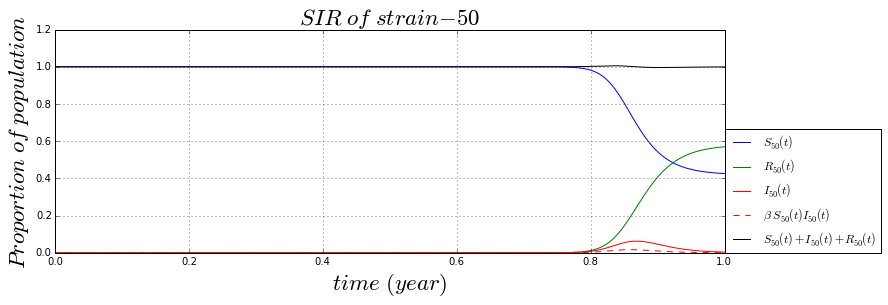

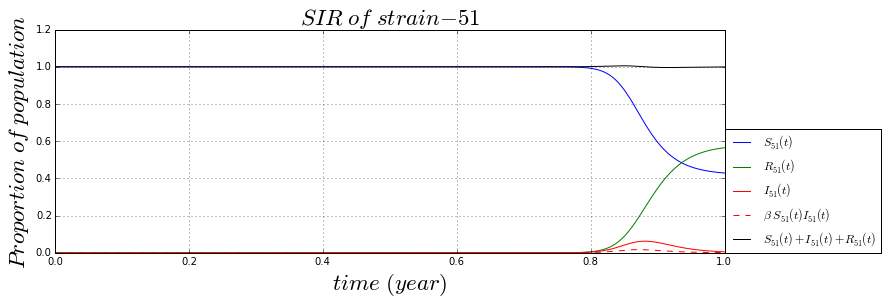

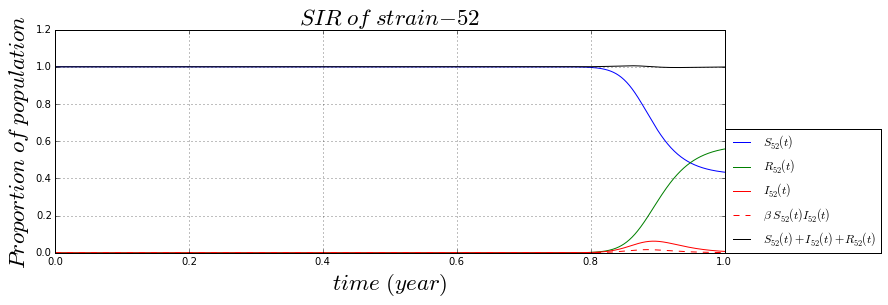

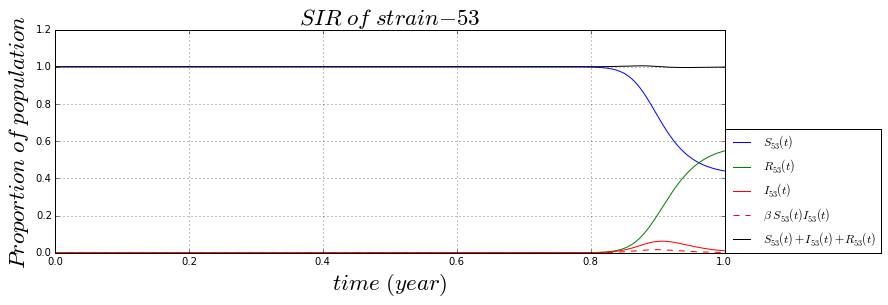

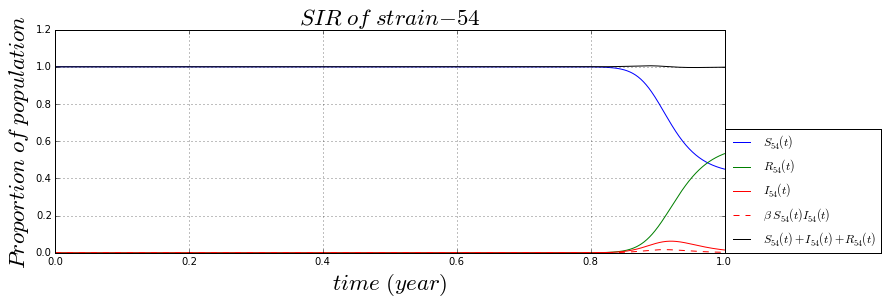

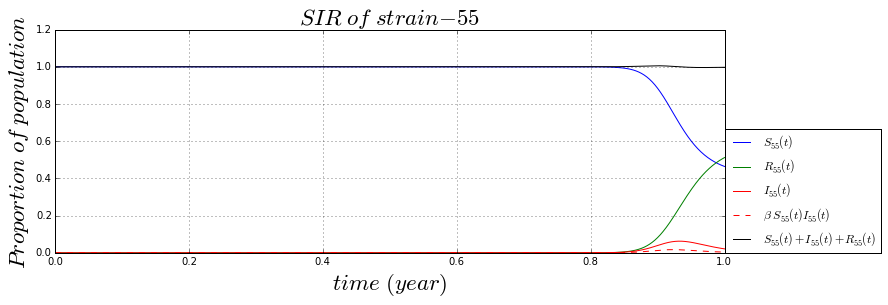

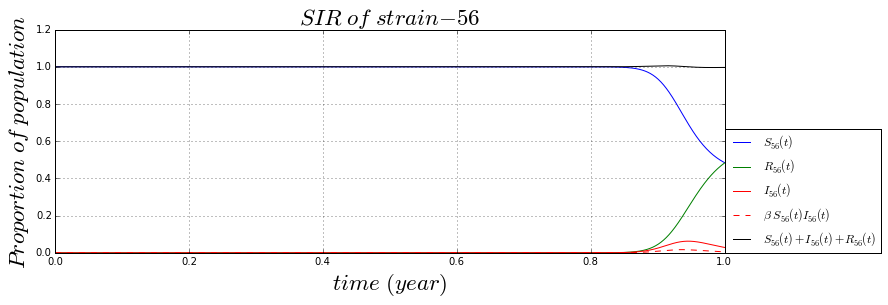

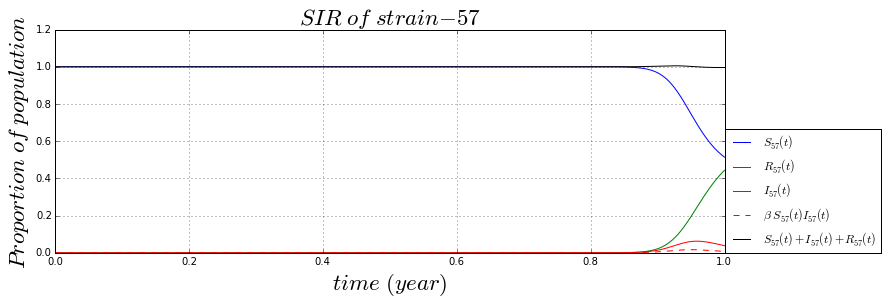

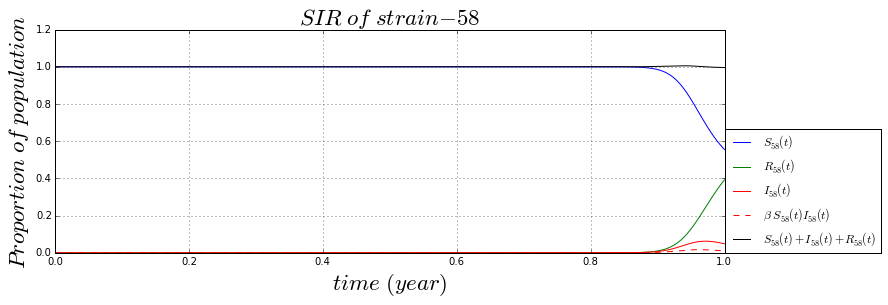

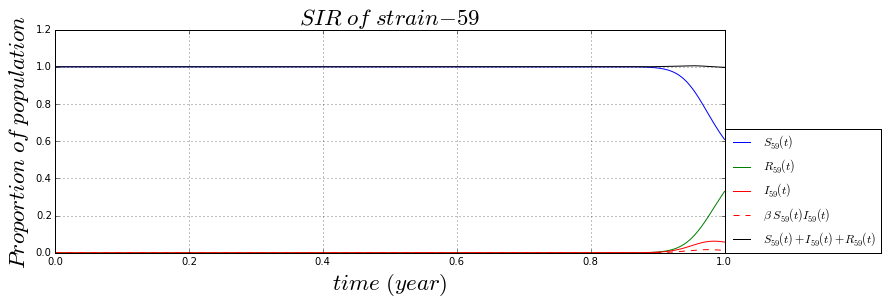

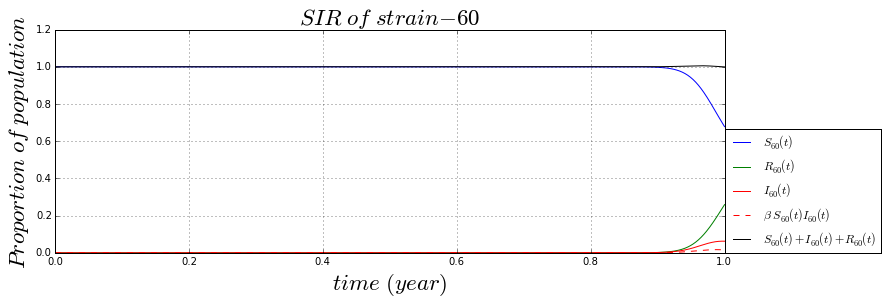

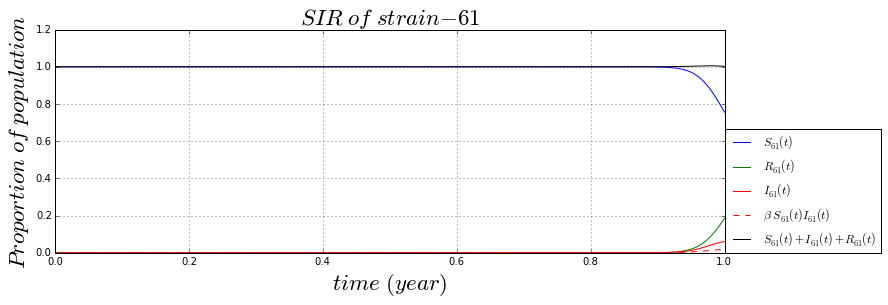

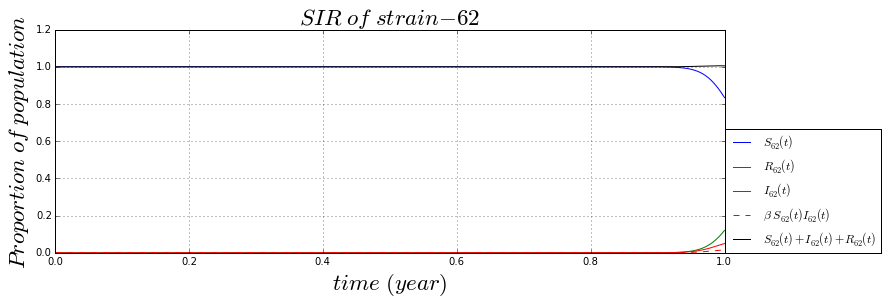

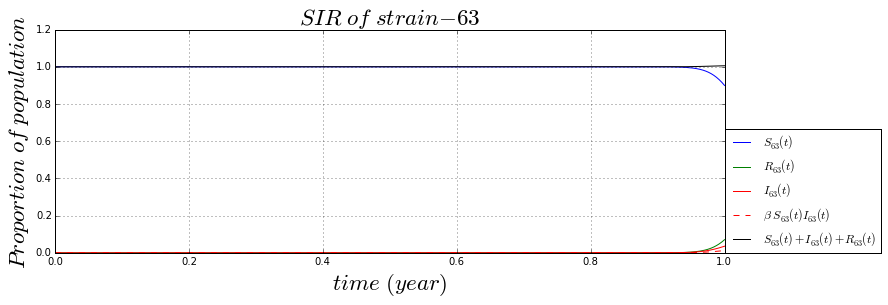

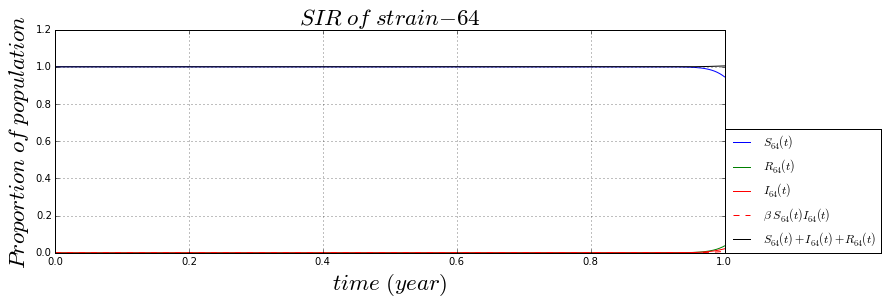

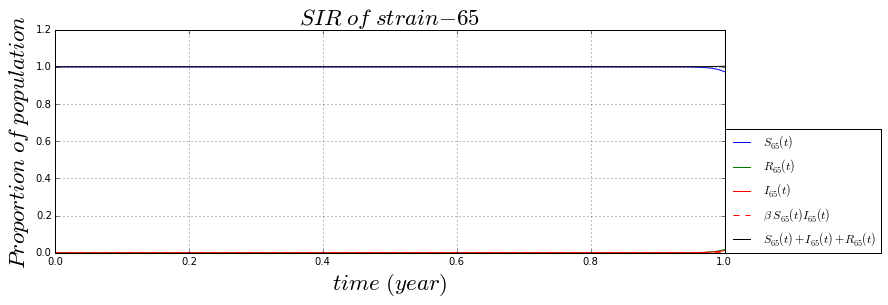

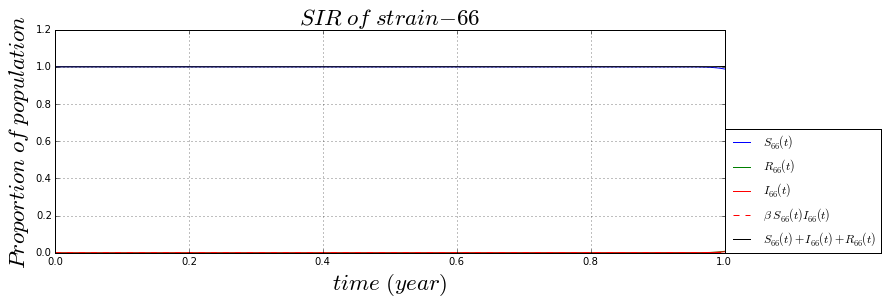

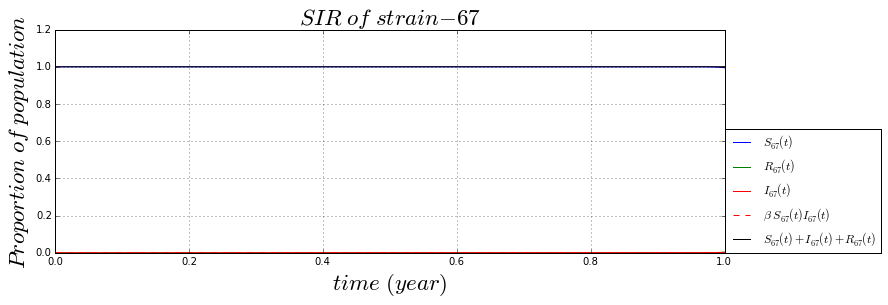

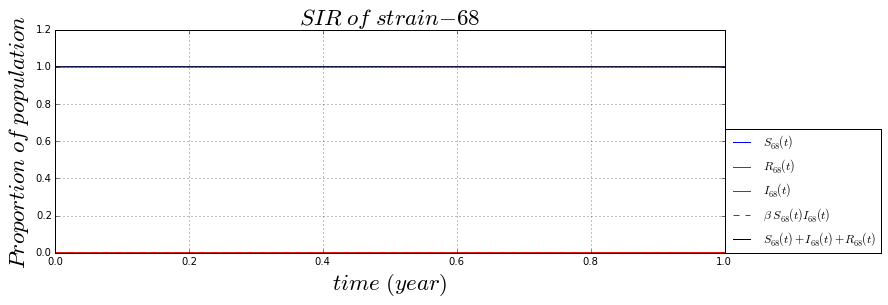

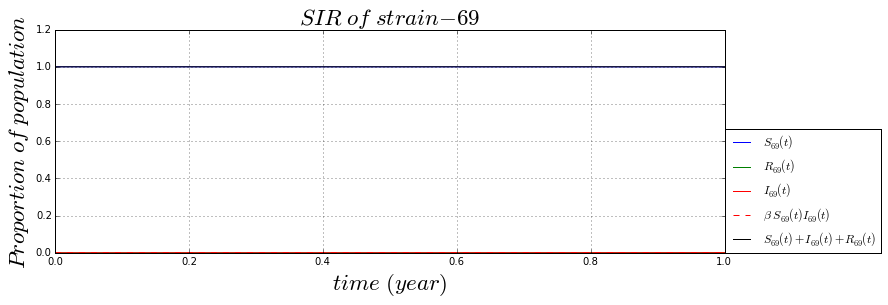

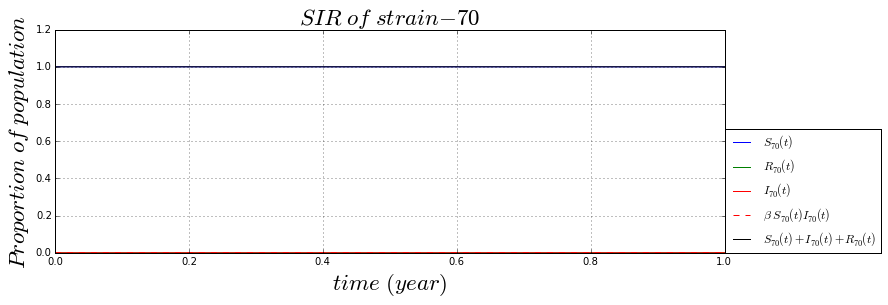

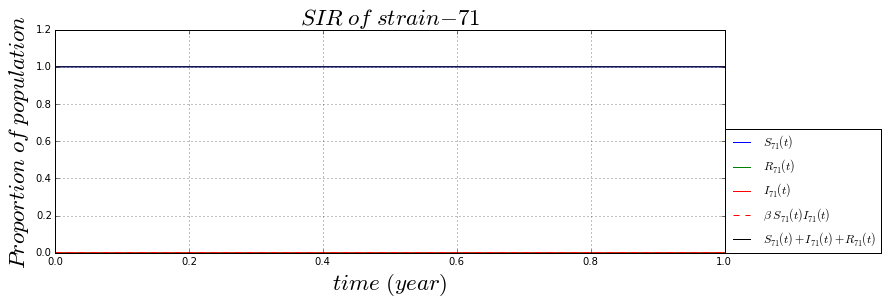

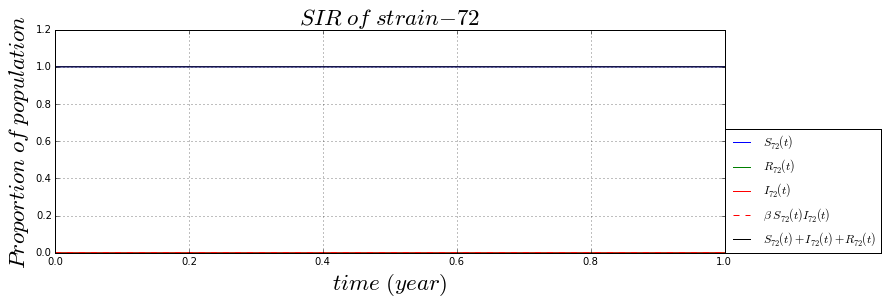

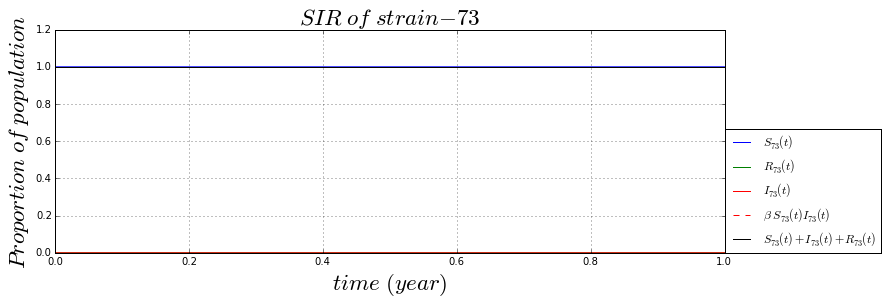

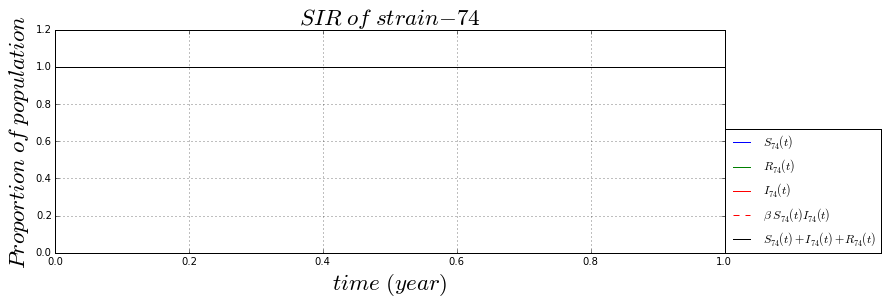

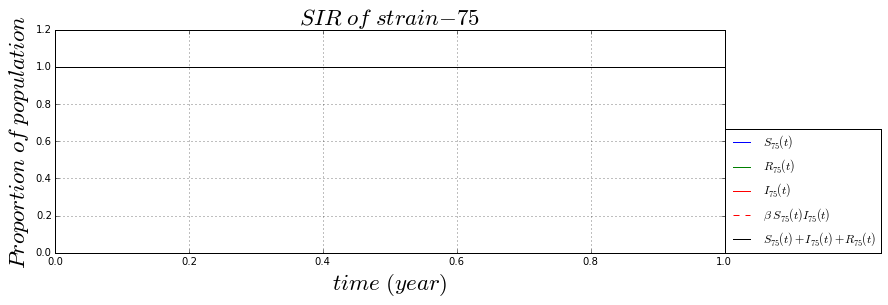

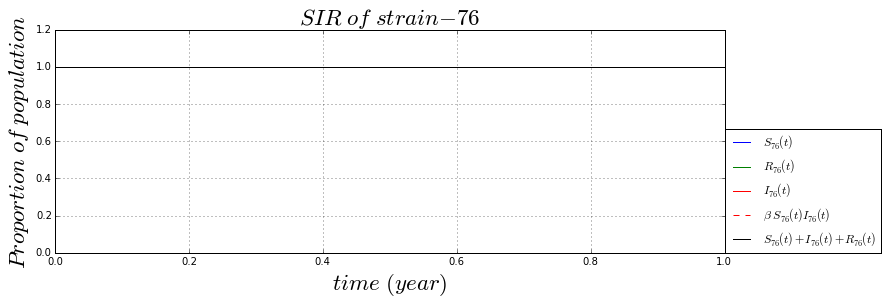

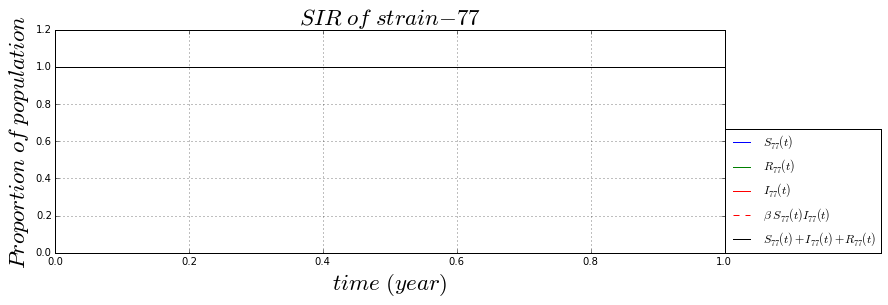

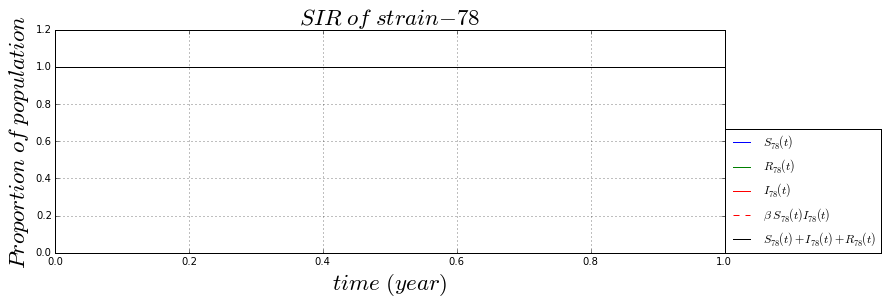

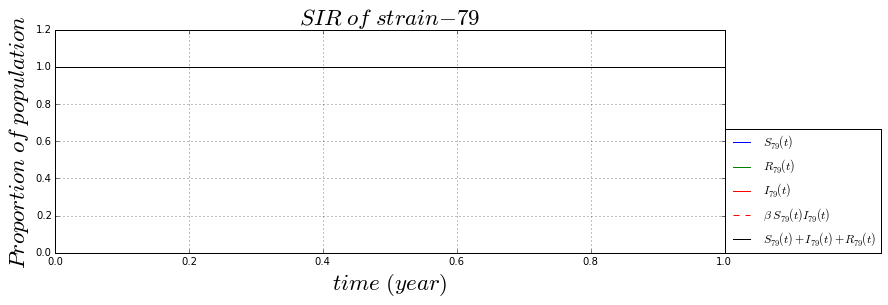

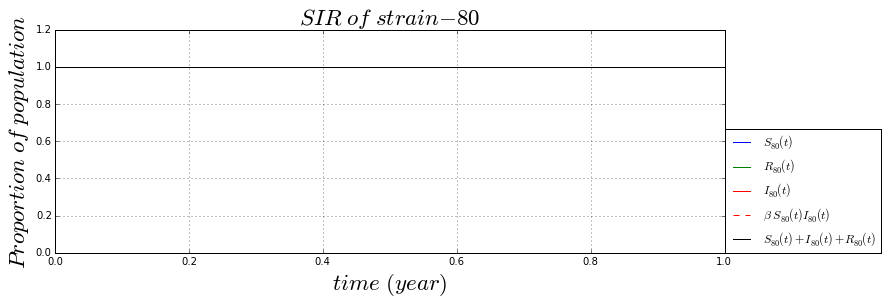

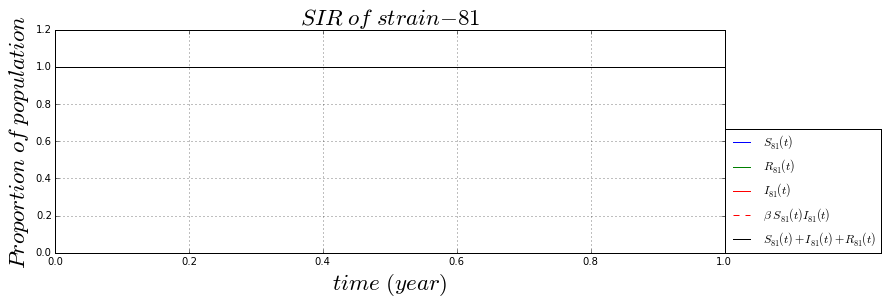

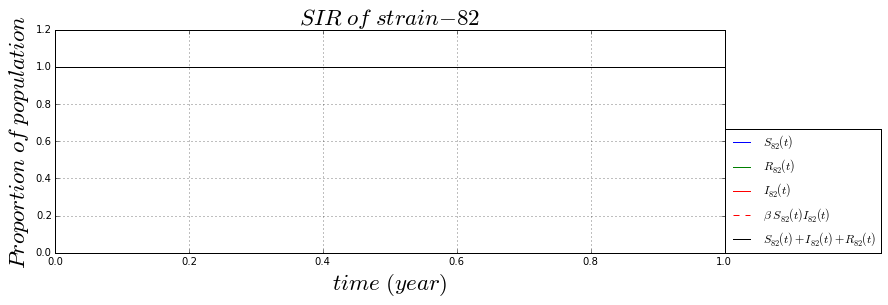

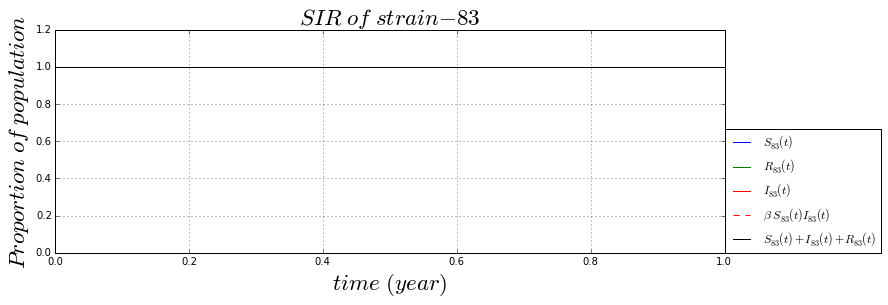

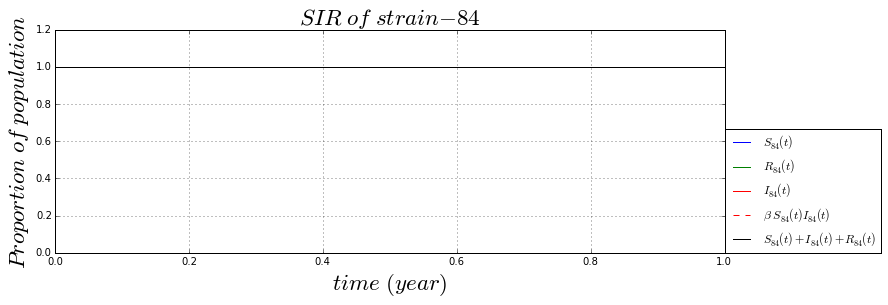

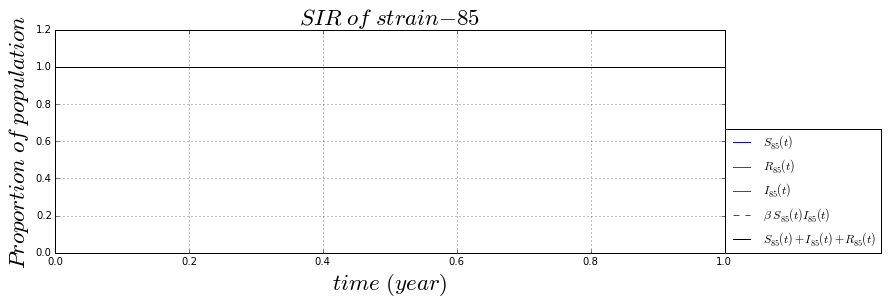

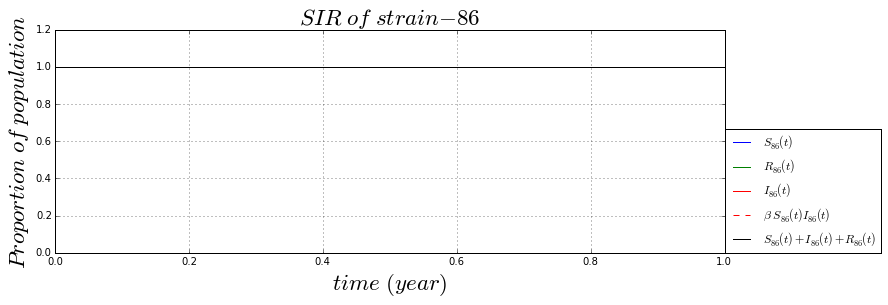

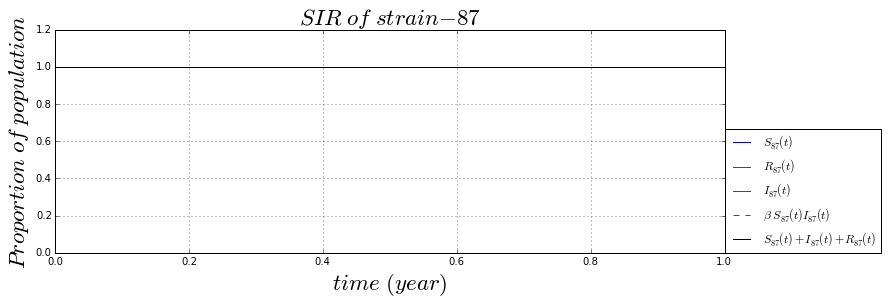

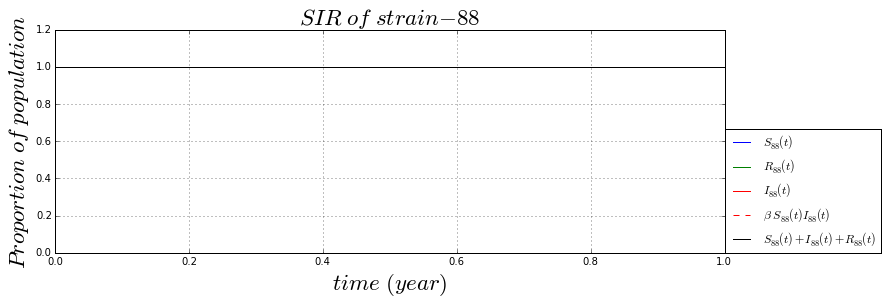

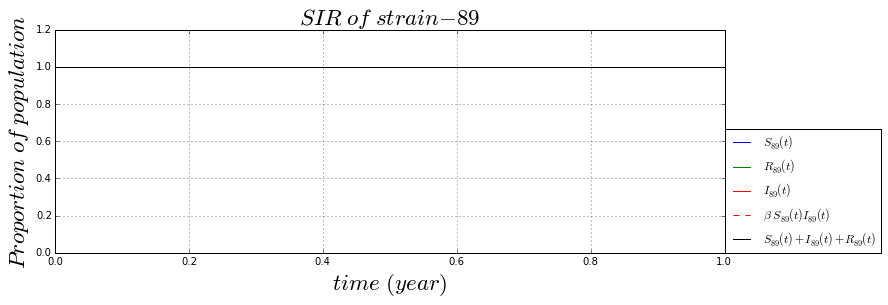

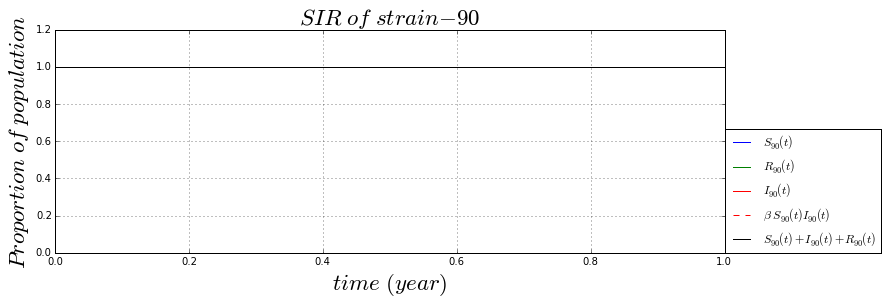

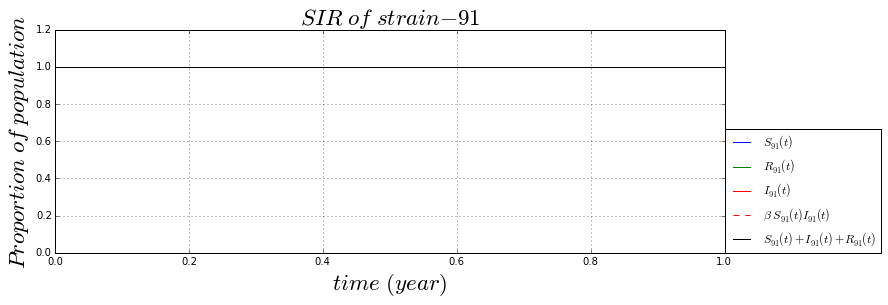

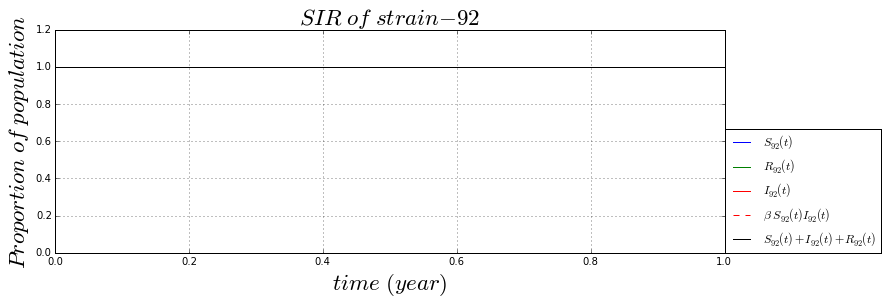

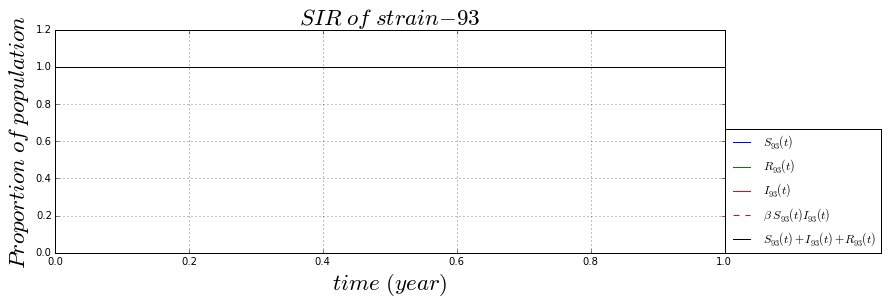

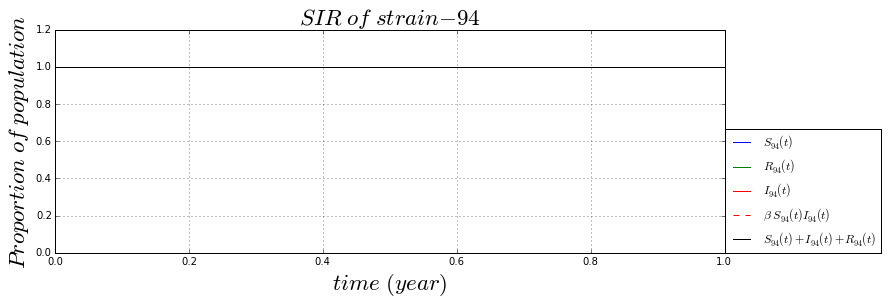

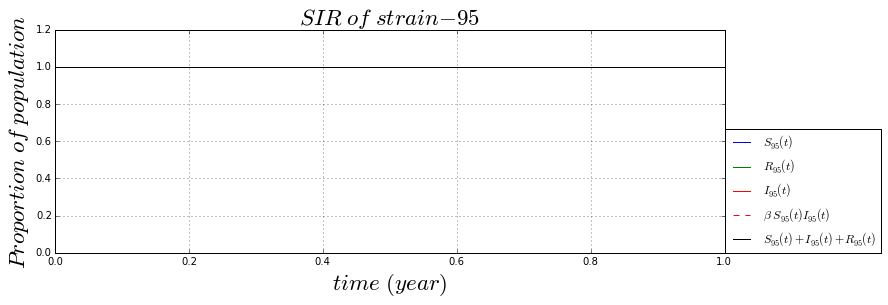

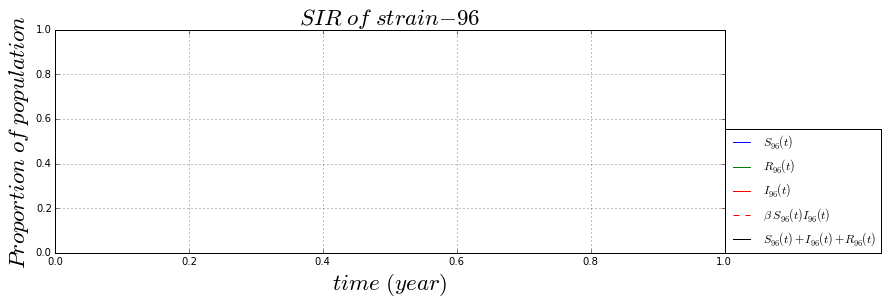

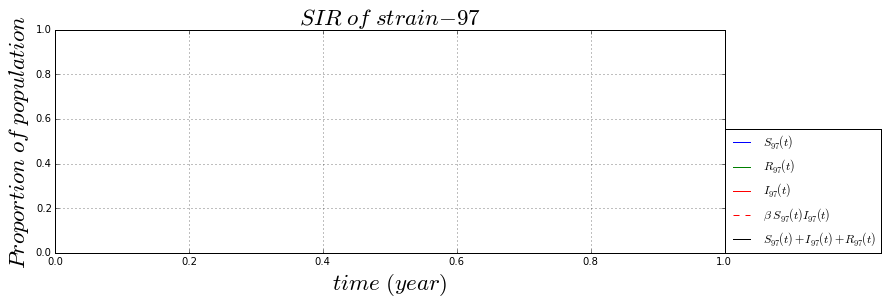

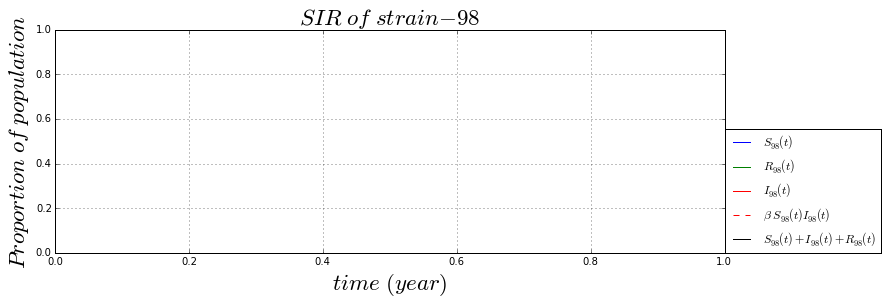

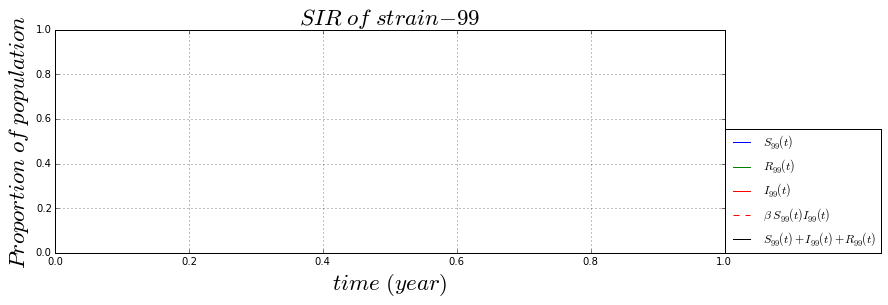

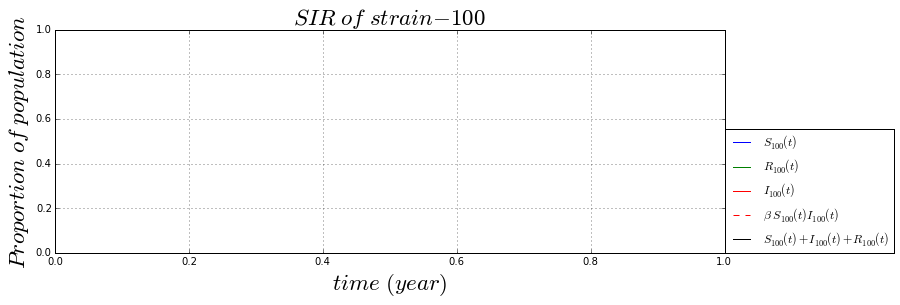

In [4]:
# plot by listing each strain 
numberingFig = numberingFig + 1
for i in range(0, totalPoint_X, 1):
    plt.figure(numberingFig, figsize = (12, 4))
    plt.plot(gT, gS[i], label = r'$ S_{%i}(t) $'%(i))
    plt.plot(gT, gR[i], label = r'$ R_{%i}(t) $'%(i))
    plt.plot(gT, gI[i], label = r'$ I_{%i}(t) $'%(i))
    plt.plot(gT, infecRate*gS[i].T*gI[i].T*day, label = r'$ \beta \ S_{%i}(t)I_{%i}(t) $'%(i, i)
             , linestyle = 'dashed', color = 'red')
    plt.plot(gT, (gS[i] + gI[i] + gR[i]).T, label = r'$ S_{%i}(t)+I_{%i}(t)+R_{%i}(t) $'%(i, i, i)
             , color = 'black')
    
    plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
    plt.ylabel(r'$ Proportion \ of \ population $', fontsize = AlvaFontSize)
    plt.grid(True)
    plt.title(r'$ SIR \ of \ strain-%i $'%(i), fontsize = AlvaFontSize)
    plt.legend(loc = (1, 0))
    plt.show()

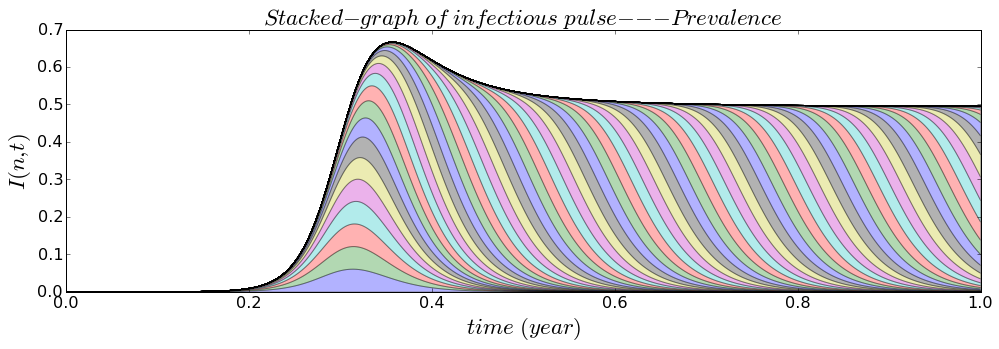

In [5]:
# Normalization stacked graph
# plotting
figure_name = '-stacked-infectious-pulse'
file_suffix = '.png'
save_figure = os.path.join(dir_path, file_name + figure_name + file_suffix)

numberingFig = numberingFig + 1
figure = plt.figure(numberingFig, figsize = (14, 5))
plt.stackplot(gT, gI, alpha = 0.3)
plt.title(r'$ Stacked-graph \ of \ infectious \ pulse---Prevalence $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ I(n,t) $', fontsize = AlvaFontSize)
plt.xticks(fontsize = AlvaFontSize*0.7)
plt.yticks(fontsize = AlvaFontSize*0.7) 
figure.tight_layout()
plt.savefig(save_figure, dpi = 100, bbox_inches='tight')
plt.show()